In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
azeri_light = pd.read_excel('data/decomposition/azeri_light.xlsx')
brent = pd.read_excel('data/decomposition/brent.xls')
gdp = pd.read_csv('data/decomposition/gdp.csv')
loan_history = pd.read_csv('data/decomposition/loan_history.csv')


In [3]:
# print(azeri_light)
# print(brent)
# print(gdp)
# print(loan_history)


In [4]:
azeri_light['year']=azeri_light['Day'].dt.year
azeri_light

,Day,Azeri_Light,year
0,2000-01-04,27.45,2000
1,2000-01-05,27.22,2000
2,2000-01-06,27.05,2000
3,2000-01-07,26.85,2000
4,2000-01-10,26.27,2000
...,...,...,...
6554,2025-10-28,66.23,2025
6555,2025-10-29,67.21,2025
6556,2025-10-30,67.31,2025
6557,2025-10-31,67.64,2025


In [5]:
brent['year'] = brent['Date'].dt.year
brent

,Date,price,year
0,1987-05-15,18.58,1987
1,1987-06-15,18.86,1987
2,1987-07-15,19.86,1987
3,1987-08-15,18.98,1987
4,1987-09-15,18.31,1987
...,...,...,...
457,2025-06-15,71.44,2025
458,2025-07-15,71.04,2025
459,2025-08-15,67.87,2025
460,2025-09-15,67.99,2025


In [6]:
gdp.rename(columns={'Year':'year'},inplace=True)
gdp

,year,GDP_current_USD
0,1960,NaN
1,1961,NaN
2,1962,NaN
3,1963,NaN
4,1964,NaN
...,...,...
60,2020,4.269300e+10
61,2021,5.482541e+10
62,2022,7.880747e+10
63,2023,7.242847e+10


In [7]:
loan_history['T_BDBEGINDATE'] = pd.to_datetime(loan_history['T_BDBEGINDATE'])
loan_history['year'] = loan_history['T_BDBEGINDATE'].dt.year
loan_history.rename(columns={'T_DMCREDITSUM':'loan_amount'},inplace=True)
loan_history

,,T_BDBEGINDATE,loan_amount,year
0,6,2009-01-29,700.0,2009
1,7,2009-01-29,700.0,2009
2,8,2009-01-30,500.0,2009
3,9,2009-01-30,500.0,2009
4,10,2009-01-30,500.0,2009
...,...,...,...,...
1048565,1048571,2023-09-20,6000.0,2023
1048566,1048572,2023-09-20,8000.0,2023
1048567,1048573,2023-09-20,1400.0,2023
1048568,1048574,2023-09-20,6000.0,2023


In [8]:
# sns.lineplot(data=azeri_light, x="Day", y="Azeri_Light")
# sns.scatterplot(data=azeri_light, x="Day", y="Azeri_Light")
# sns.relplot(data=azeri_light, x="Day", y="Azeri_Light")
# sns.violinplot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.histplot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.kdeplot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.displot(data=azeri_light, x="Day") #, y="Azeri_Light")
# sns.ecdfplot(data=azeri_light, x="Day") #, y="Azeri_Light")


In [15]:
# plt.figure(figsize=(16, 8), dpi=150)
# azeri_light['Azeri_Light'].plot(label='Azeri_Light', color='blue')
# brent['price'].plot(label='Brent', color='red')
# gdp['GDP_current_USD'].plot(label='GDP', color='green')
# loan_history['loan_amount'].plot(label='Loan_Sales', color='orange')
# plt.title('Combined Plot')
# plt.xlabel('Index Label')
# plt.ylabel('Value Label')
# plt.legend()
# plt.grid(True)
# plt.show()

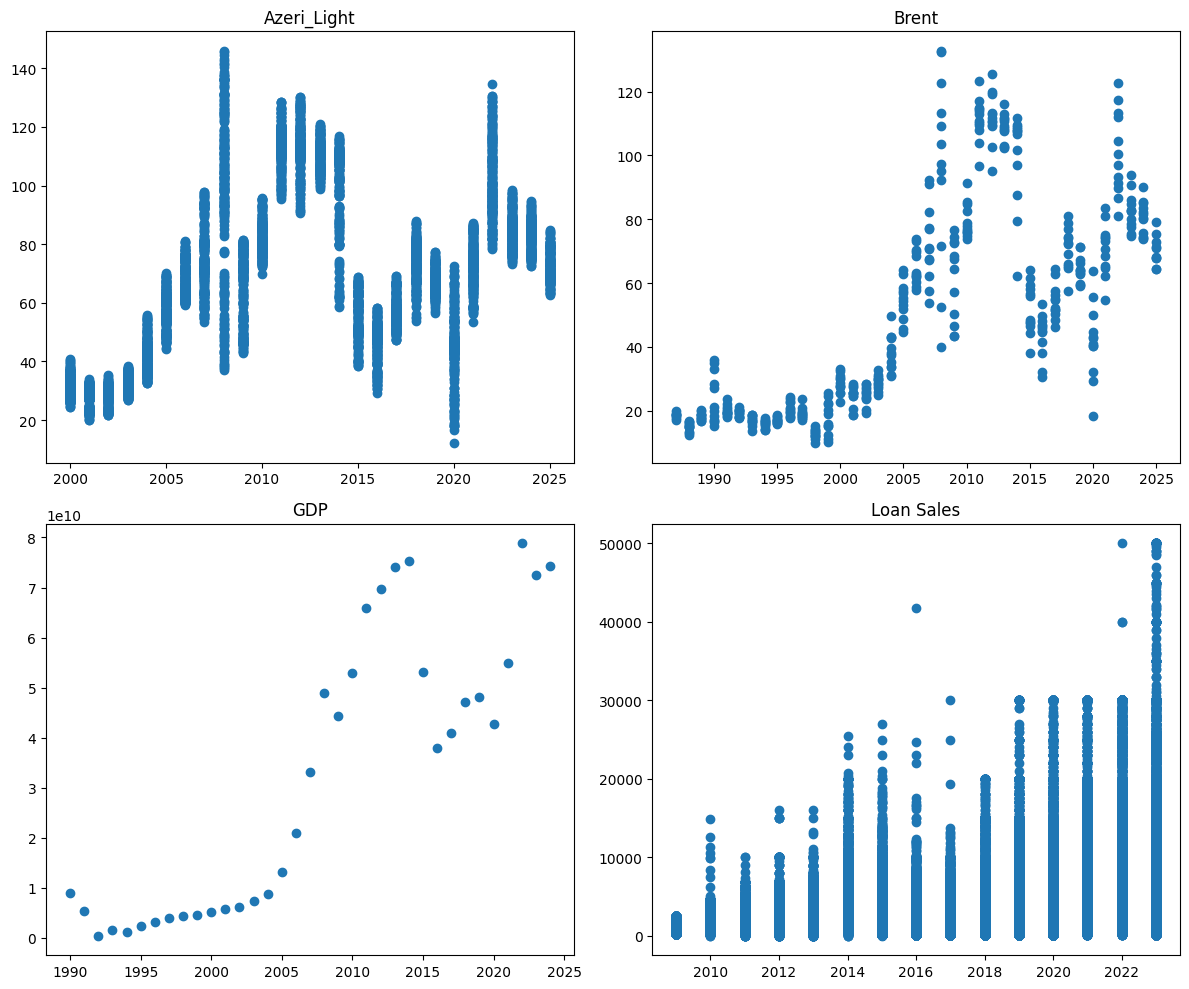

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # Creates a 2x2 grid of plots

# Plot each DataFrame on a different axes
axes[0, 0].scatter(azeri_light['year'], azeri_light['Azeri_Light'])
axes[0, 0].set_title('Azeri_Light')

axes[0, 1].scatter(brent['year'], brent['price'])
axes[0, 1].set_title('Brent')

axes[1, 0].scatter(gdp['year'], gdp['GDP_current_USD'])
axes[1, 0].set_title('GDP')

axes[1, 1].scatter(loan_history['year'], loan_history['loan_amount'])
axes[1, 1].set_title('Loan Sales')

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()


<Axes: xlabel='year', ylabel='Azeri_Light'>

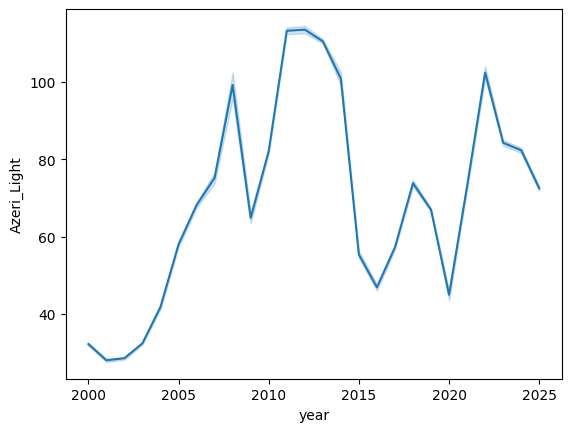

In [9]:
sns.lineplot(data=azeri_light, x="year", y="Azeri_Light")

<Axes: xlabel='year', ylabel='price'>

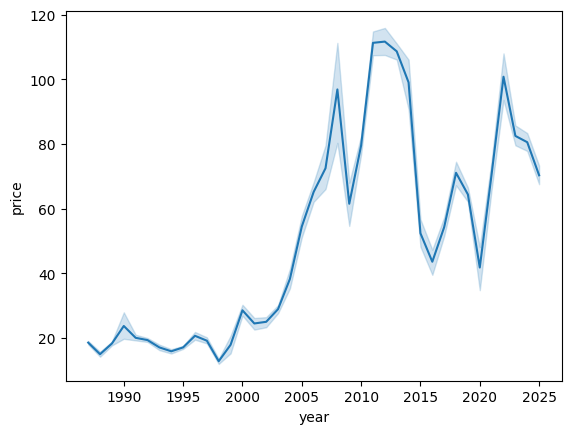

In [10]:
sns.lineplot(data=brent, x="year", y="price")


<Axes: xlabel='year', ylabel='GDP_current_USD'>

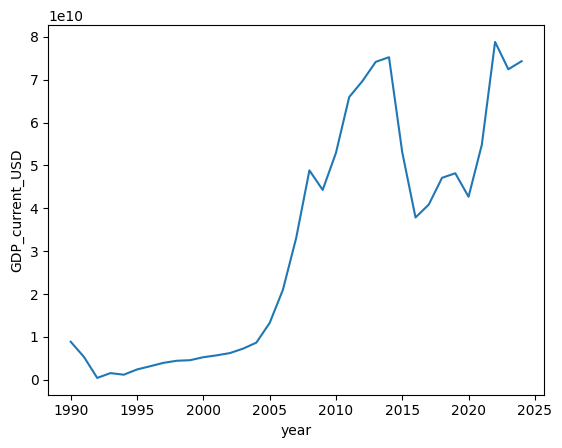

In [11]:
sns.lineplot(data=gdp, x="year", y="GDP_current_USD")


<Axes: xlabel='year', ylabel='loan_amount'>

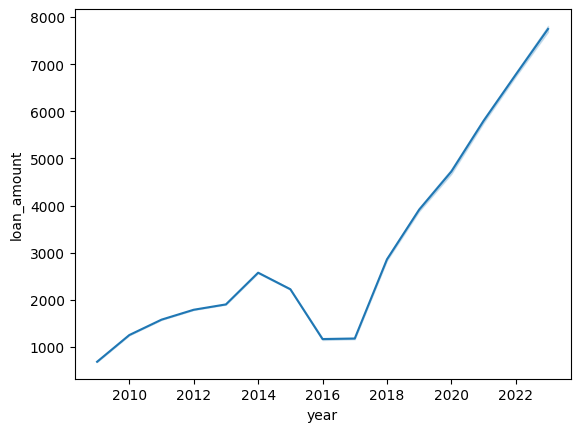

In [12]:
sns.lineplot(data=loan_history, x="year", y="loan_amount")